In [1]:
import pandas as pd
import re
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
df = pd.read_csv('data/Data Collection - Sheet1.csv')
df.head(10)

,text,target
0,ខ្ញុំស្រលាញ់ផលិតផលនេះណាស់,positive
1,មិនពេញចិត្តទេ តើអ្វីកើតឡើង?,negative
2,ផលិតផលមធ្យមៗ គ្មានអ្វីពិសេស,neutral
3,ពលរដ្ឋ៣ភូមិក្នុងស្រុកត្រាំកក់ ទទួលបានផ្លូវបេតុ...,positive
4,ផ្លូវបេតុងនេះមានប្រវែងជាង១៦០០ម៉ែត្រ,neutral
5,ប្រជាពលរដ្ឋចំនួន៣ភូមិ នឹងលែងជួបការលំបាកក្នុង?ក...,positive
6,សិស្សានុសិស្សដែលធ្វើដំណើរឆ្លងកាត់នឹងទទួលបានភាព...,positive
7,អាជ្ញាធរស្រុកត្រាំកក់បានបើកការដ្ឋានសាងសង់ផ្លូវ...,positive
8,ផ្លូវបេតុងនេះមានប្រវែង១៦៣៧ម៉ែត្រ//,neutral
9,ពិធីបើកការដ្ឋានធ្វើឡើងក្រោមអធិបតីភាពលោក កេត ម៉ៅ,neutral


In [3]:
df.shape

(621, 2)

### Text Cleaning

In [4]:
def khmer_preprocess(text):
    # Unicode normalization
    text = unicodedata.normalize("NFC", text)
    
    # Remove numbers and punctuation
    text = re.sub(r"[^\u1780-\u17FF\s]", "", text)
    
    # Remove spaces 
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

df["clean_text"] = df["text"].apply(khmer_preprocess)


In [5]:
print(df.head(10).to_markdown(index=False))

| text                                                   | target   | clean_text                                         |
|:-------------------------------------------------------|:---------|:---------------------------------------------------|
| ខ្ញុំស្រលាញ់ផលិតផលនេះណាស់                                         | positive | ខ្ញុំស្រលាញ់ផលិតផលនេះណាស់                                     |
| មិនពេញចិត្តទេ តើអ្វីកើតឡើង?                                      | negative | មិនពេញចិត្តទេ តើអ្វីកើតឡើង                                   |
| ផលិតផលមធ្យមៗ គ្មានអ្វីពិសេស                                    | neutral  | ផលិតផលមធ្យមៗ គ្មានអ្វីពិសេស                                |
| ពលរដ្ឋ៣ភូមិក្នុងស្រុកត្រាំកក់ ទទួលបានផ្លូវបេតុងមួយខ្សែដើម្បីសម្រួលដល់ការធ្វើដំណើរ::// | positive | ពលរដ្ឋ៣ភូមិក្នុងស្រុកត្រាំកក់ ទទួលបានផ្លូវបេតុងមួយខ្សែដើម្បីសម្រួលដល់ការធ្វើដំណើរ |
| ផ្លូវបេតុងនេះមានប្រវែងជាង១៦០០ម៉ែត្រ                                 | neutral  | ផ្លូវបេតុងនេះមានប្រវែងជាង១៦០០ម៉ែត្រ                        

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["target"])

# positive=2, neutral=1, negative=0 (order may vary)
print(label_encoder.classes_)
df


['negative' 'neutral' 'positive' 'sentiment']


['negative' 'neutral' 'positive' 'sentiment']


,text,target,clean_text,label
0,ខ្ញុំស្រលាញ់ផលិតផលនេះណាស់,positive,ខ្ញុំស្រលាញ់ផលិតផលនេះណាស់,2
1,មិនពេញចិត្តទេ តើអ្វីកើតឡើង?,negative,មិនពេញចិត្តទេ តើអ្វីកើតឡើង,0
2,ផលិតផលមធ្យមៗ គ្មានអ្វីពិសេស,neutral,ផលិតផលមធ្យមៗ គ្មានអ្វីពិសេស,1
3,ពលរដ្ឋ៣ភូមិក្នុងស្រុកត្រាំកក់ ទទួលបានផ្លូវបេតុ...,positive,ពលរដ្ឋ៣ភូមិក្នុងស្រុកត្រាំកក់ ទទួលបានផ្លូវបេតុ...,2
4,ផ្លូវបេតុងនេះមានប្រវែងជាង១៦០០ម៉ែត្រ,neutral,ផ្លូវបេតុងនេះមានប្រវែងជាង១៦០០ម៉ែត្រ,1
...,...,...,...,...
616,វិធានការនេះដើម្បីបង្ការហានីភ័យ,positive,វិធានការនេះដើម្បីបង្ការហានីភ័យ,2
617,ផ្លែសំរងមានតម្លៃ៥ម៉ឺនរៀលក្នុងមួយគីឡូក្រាម,positive,ផ្លែសំរងមានតម្លៃ៥ម៉ឺនរៀលក្នុងមួយគីឡូក្រាម,2
618,ផ្លែសំរងលក់នៅទីផ្សារបាន៦ម៉ឺនរៀល,positive,ផ្លែសំរងលក់នៅទីផ្សារបាន៦ម៉ឺនរៀល,2
619,អតិថិជនជឿថាផ្លែសំរងល្អសុខភាព,positive,អតិថិជនជឿថាផ្លែសំរងល្អសុខភាព,2


C:\Users\seakl\AppData\Local\Temp\ipykernel_21164\4234943245.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=df, order=df["target"].value_counts().index, palette="viridis")


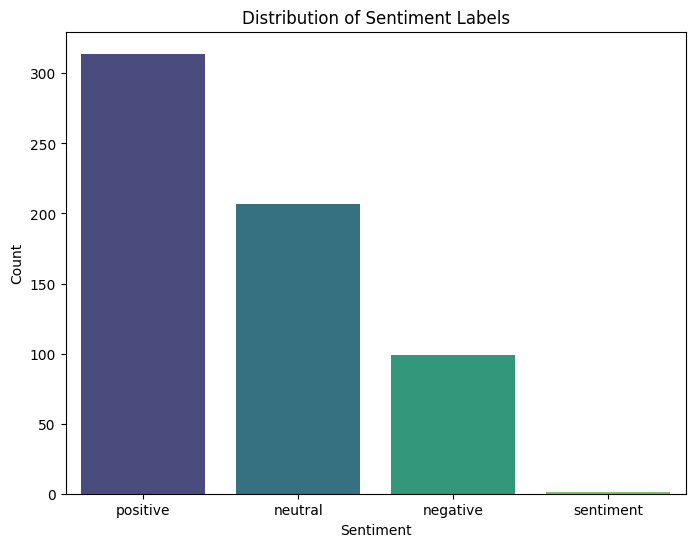

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x="target", data=df, order=df["target"].value_counts().index, palette="viridis")
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [8]:
### Remove row = 'text'
df = df[df['text'].str.lower() != 'text']
df.reset_index(drop=True, inplace=True)
df.head(10)


,text,target,clean_text,label
0,ខ្ញុំស្រលាញ់ផលិតផលនេះណាស់,positive,ខ្ញុំស្រលាញ់ផលិតផលនេះណាស់,2
1,មិនពេញចិត្តទេ តើអ្វីកើតឡើង?,negative,មិនពេញចិត្តទេ តើអ្វីកើតឡើង,0
2,ផលិតផលមធ្យមៗ គ្មានអ្វីពិសេស,neutral,ផលិតផលមធ្យមៗ គ្មានអ្វីពិសេស,1
3,ពលរដ្ឋ៣ភូមិក្នុងស្រុកត្រាំកក់ ទទួលបានផ្លូវបេតុ...,positive,ពលរដ្ឋ៣ភូមិក្នុងស្រុកត្រាំកក់ ទទួលបានផ្លូវបេតុ...,2
4,ផ្លូវបេតុងនេះមានប្រវែងជាង១៦០០ម៉ែត្រ,neutral,ផ្លូវបេតុងនេះមានប្រវែងជាង១៦០០ម៉ែត្រ,1
5,ប្រជាពលរដ្ឋចំនួន៣ភូមិ នឹងលែងជួបការលំបាកក្នុង?ក...,positive,ប្រជាពលរដ្ឋចំនួន៣ភូមិ នឹងលែងជួបការលំបាកក្នុងកា...,2
6,សិស្សានុសិស្សដែលធ្វើដំណើរឆ្លងកាត់នឹងទទួលបានភាព...,positive,សិស្សានុសិស្សដែលធ្វើដំណើរឆ្លងកាត់នឹងទទួលបានភាព...,2
7,អាជ្ញាធរស្រុកត្រាំកក់បានបើកការដ្ឋានសាងសង់ផ្លូវ...,positive,អាជ្ញាធរស្រុកត្រាំកក់បានបើកការដ្ឋានសាងសង់ផ្លូវ...,2
8,ផ្លូវបេតុងនេះមានប្រវែង១៦៣៧ម៉ែត្រ//,neutral,ផ្លូវបេតុងនេះមានប្រវែង១៦៣៧ម៉ែត្រ,1
9,ពិធីបើកការដ្ឋានធ្វើឡើងក្រោមអធិបតីភាពលោក កេត ម៉ៅ,neutral,ពិធីបើកការដ្ឋានធ្វើឡើងក្រោមអធិបតីភាពលោក កេត ម៉ៅ,1


In [9]:
df.shape

(620, 4)

In [10]:
df.value_counts('target', normalize=True)


target
positive    0.506452
neutral     0.333871
negative    0.159677
Name: proportion, dtype: float64

C:\Users\seakl\AppData\Local\Temp\ipykernel_21164\3583030055.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=df, order=df["target"].value_counts().index, palette="viridis", stat="percent")


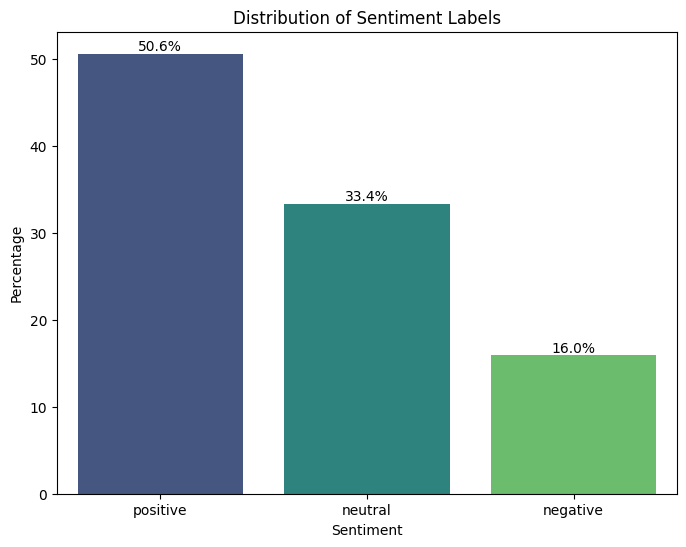

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x="target", data=df, order=df["target"].value_counts().index, palette="viridis", stat="percent")
# show percentages on graph
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height), 
                       ha='center', va='bottom')
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Percentage")
plt.show()

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),   # unigrams + bigrams
    max_features=3000
)

X = vectorizer.fit_transform(df["clean_text"])
y = df["label"]


In [13]:
X.toarray()[:5]  # Show first 5 rows of the feature array

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1649397 , 0.        , 0.22838201, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(5, 3000))

In [14]:
print(vectorizer.get_feature_names_out()[:20])  # Show first 20 feature names

['កក' 'កក ងស' 'កក ទទ' 'កក នប' 'កក យជ' 'កក រដ' 'កក រប' 'កក រព' 'កកម'
 'កកម ពស' 'កកស' 'កកស កម' 'កខ' 'កខ មត' 'កខ មល' 'កគ' 'កគ លនយ' 'កងកម' 'កងទ'
 'កច']


## Train-Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training label distribution:\n{pd.Series(y_train).value_counts()}")
print(f"\nTest label distribution:\n{pd.Series(y_test).value_counts()}")

Training set size: 496
Test set size: 124
Training label distribution:
label
2    251
1    166
0     79
Name: count, dtype: int64

Test label distribution:
label
2    63
1    41
0    20
Name: count, dtype: int64


In [16]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {
    i: class_weights[i] for i in range(len(class_weights))
}

print("STEP 5: Class Weights")
for i, weight in enumerate(class_weights):
    label_name = label_encoder.classes_[i]
    print(f"Class: {label_name} (label {i}) → Weight: {weight:.4f}")

STEP 5: Class Weights
Class: negative (label 0) → Weight: 2.0928
Class: neutral (label 1) → Weight: 0.9960
Class: positive (label 2) → Weight: 0.6587


In [17]:
log_reg = LogisticRegression(class_weight=class_weight_dict, max_iter=1000)

param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["lbfgs", "saga", "newton-cg"]
}

grid_lr = GridSearchCV(
    log_reg,
    param_grid_lr,
    scoring="f1_macro",
    cv=2
)

grid_lr.fit(X_train, y_train)

print("STEP 6: Logistic Regression Best Parameters")
print(grid_lr.best_params_)

STEP 6: Logistic Regression Best Parameters
{'C': 0.1, 'solver': 'saga'}


Test Accuracy: 0.4597

Classification Report:
              precision    recall  f1-score   support

    negative       0.55      0.30      0.39        20
     neutral       0.34      0.41      0.37        41
    positive       0.54      0.54      0.54        63

    accuracy                           0.46       124
   macro avg       0.48      0.42      0.43       124
weighted avg       0.47      0.46      0.46       124



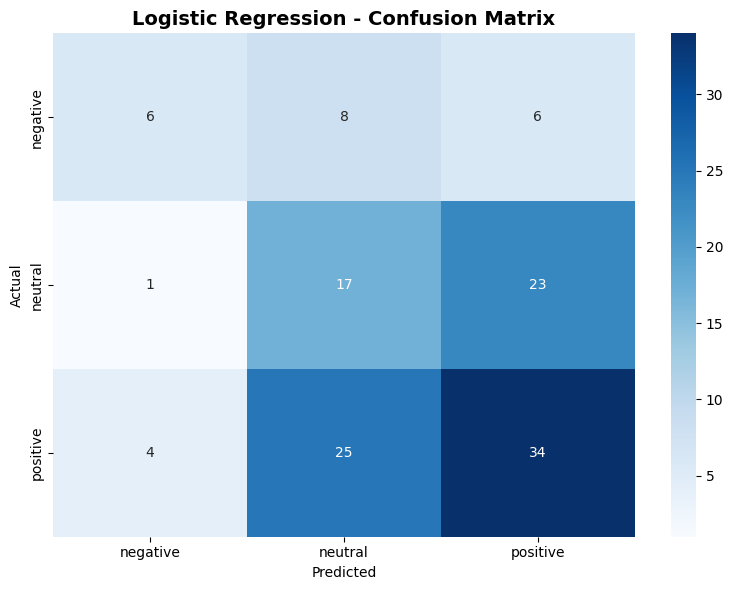

In [18]:
# Evaluate Logistic Regression model
# Make predictions using the best model
y_pred = grid_lr.predict(X_test)

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {lr_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
target_names = [label_encoder.classes_[i] for i in sorted(np.unique(y))]
print(classification_report(y_test, y_pred, target_names=target_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [19]:
svm = SVC(class_weight=class_weight_dict)

param_grid_svm = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"]
}

grid_svm = GridSearchCV(
    svm,
    param_grid_svm,
    scoring="f1_macro",
    cv=2
)

grid_svm.fit(X_train, y_train)

print("STEP 7: SVM Best Parameters")
print(grid_svm.best_params_)

STEP 7: SVM Best Parameters
{'C': 10, 'kernel': 'linear'}


Test Accuracy: 0.5161

Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.20      0.31        20
     neutral       0.39      0.32      0.35        41
    positive       0.55      0.75      0.64        63

    accuracy                           0.52       124
   macro avg       0.54      0.42      0.43       124
weighted avg       0.52      0.52      0.49       124



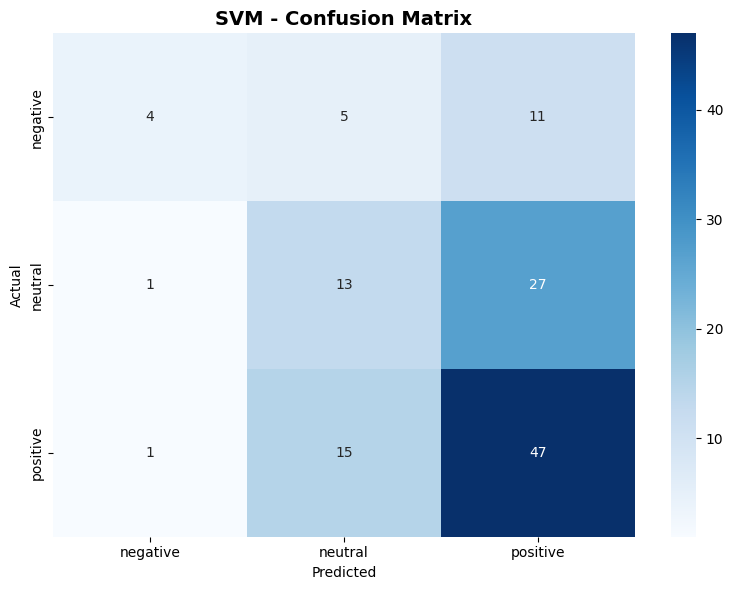

In [20]:
# Evaluate SVM model
# Make predictions using the best model
y_pred = grid_svm.predict(X_test)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {svm_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
target_names = [label_encoder.classes_[i] for i in sorted(np.unique(y))]
print(classification_report(y_test, y_pred, target_names=target_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('SVM - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [21]:
nb = MultinomialNB()

param_grid_nb = {
    "alpha": [0.1, 0.5, 1.0, 2.0]
}

grid_nb = GridSearchCV(
    nb,
    param_grid_nb,
    scoring="f1_macro",
    cv=2
)

grid_nb.fit(X_train, y_train)

print("STEP 8: Naive Bayes Best Parameters")
print(grid_nb.best_params_)

STEP 8: Naive Bayes Best Parameters
{'alpha': 0.1}


Test Accuracy: 0.4919

Classification Report:
              precision    recall  f1-score   support

    negative       0.33      0.30      0.32        20
     neutral       0.44      0.46      0.45        41
    positive       0.57      0.57      0.57        63

    accuracy                           0.49       124
   macro avg       0.45      0.44      0.45       124
weighted avg       0.49      0.49      0.49       124



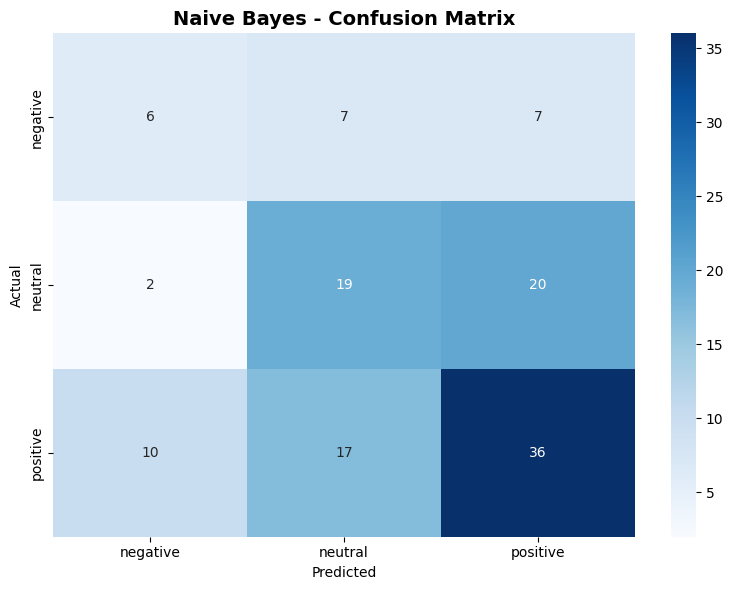

In [22]:
# Evaluate Naive Bayes model
# Make predictions using the best model
y_pred = grid_nb.predict(X_test)

# Calculate accuracy
nb_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {nb_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
target_names = [label_encoder.classes_[i] for i in sorted(np.unique(y))]
print(classification_report(y_test, y_pred, target_names=target_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Naive Bayes - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Model Performance Improvements

Based on current results:
- Logistic Regression: 45.97%
- SVM: 51.61% (best)
- Naive Bayes: 49.19%

**Strategies to improve:**
1. ✅ Increase data collection
2. ✅ Better text preprocessing (stopwords, stemming)
3. ✅ Feature engineering improvements
4. ✅ Try ensemble models
5. ✅ Advanced deep learning models

### Strategy 1: Enhanced Text Preprocessing with Stopwords

In [23]:
# Enhanced text preprocessing with stopwords removal
khmer_stopwords = [
    'នេះ', 'នោះ', 'នឹង', 'ដែល', 'ទៅ', 'មក', 'ឲ្យ', 'បាន', 'ជា', 'ហើយ',
    'ដើម្បី', 'ពី', 'តាម', 'រួច', 'ផង', 'ទៀត', 'ទេ', 'អត់', 'ថា', 'គឺ',
    'ក៏', 'យ៉ាង', 'របស់', 'ចំពោះ', 'ដល់', 'ជាមួយ', 'និង', 'ឬ', 'ប៉ុន្តែ'
]

def khmer_preprocess_enhanced(text):
    # Unicode normalization
    text = unicodedata.normalize("NFC", text)
    
    # Remove numbers and punctuation
    text = re.sub(r"[^\u1780-\u17FF\s]", "", text)
    
    # Remove spaces 
    text = re.sub(r"\s+", " ", text).strip()
    
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in khmer_stopwords]
    text = " ".join(words)
    
    return text

df["enhanced_text"] = df["text"].apply(khmer_preprocess_enhanced)
print("Enhanced preprocessing completed!")
print(f"Sample: {df['enhanced_text'].iloc[0]}")

Enhanced preprocessing completed!
Sample: ខ្ញុំស្រលាញ់ផលិតផលនេះណាស់


C:\Users\seakl\AppData\Local\Temp\ipykernel_21164\2813739967.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["enhanced_text"] = df["text"].apply(khmer_preprocess_enhanced)


### Strategy 2: Improved TF-IDF Features

In [24]:
# Improved TF-IDF vectorizer with better parameters
vectorizer_enhanced = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 3),      # unigrams + bigrams + trigrams
    max_features=5000,       # increased from 3000
    min_df=2,                # ignore terms appearing in less than 2 documents
    max_df=0.8,              # ignore terms appearing in more than 80% of documents
    sublinear_tf=True        # apply sublinear tf scaling
)

X_enhanced = vectorizer_enhanced.fit_transform(df["enhanced_text"])
y_enhanced = df["label"]

print(f"Original features: {X.shape[1]}")
print(f"Enhanced features: {X_enhanced.shape[1]}")

Original features: 3000
Enhanced features: 788


In [25]:
# New train-test split with enhanced features
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42, stratify=y_enhanced
)

print(f"Enhanced training set size: {X_train_enh.shape[0]}")
print(f"Enhanced test set size: {X_test_enh.shape[0]}")

Enhanced training set size: 496
Enhanced test set size: 124


### Strategy 3: Ensemble Model (Random Forest)

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest with class weights
rf = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1
)

print("Training Random Forest...")
grid_rf.fit(X_train_enh, y_train_enh)

print("\nBest Parameters:")
print(grid_rf.best_params_)
print(f"Best CV Score: {grid_rf.best_score_:.4f}")

Training Random Forest...

Best Parameters:
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Score: 0.4487


Random Forest Test Accuracy: 0.4758

Classification Report:
              precision    recall  f1-score   support

    negative       0.42      0.40      0.41        20
     neutral       0.36      0.39      0.38        41
    positive       0.57      0.56      0.56        63

    accuracy                           0.48       124
   macro avg       0.45      0.45      0.45       124
weighted avg       0.48      0.48      0.48       124



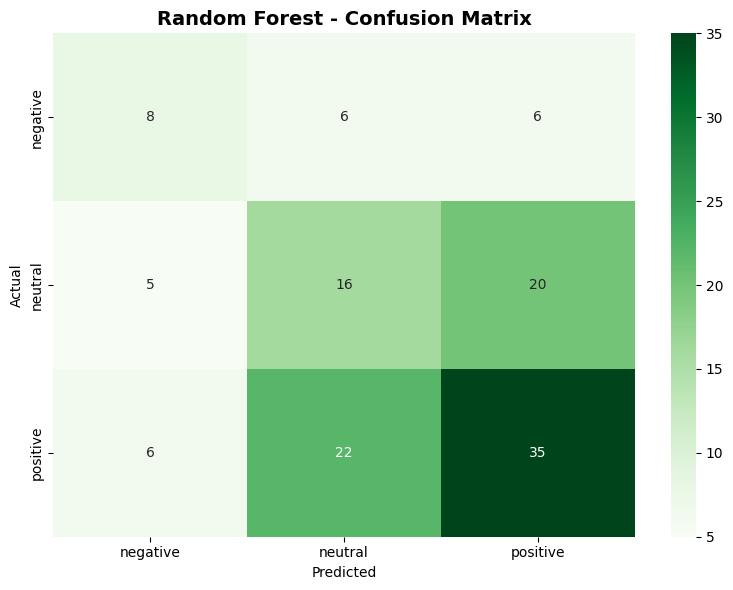

In [27]:
# Evaluate Random Forest
y_pred_rf = grid_rf.predict(X_test_enh)

rf_accuracy = accuracy_score(y_test_enh, y_pred_rf)
print(f"Random Forest Test Accuracy: {rf_accuracy:.4f}")

print("\nClassification Report:")
target_names = [label_encoder.classes_[i] for i in sorted(np.unique(y_enhanced))]
print(classification_report(y_test_enh, y_pred_rf, target_names=target_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_rf = confusion_matrix(y_test_enh, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Strategy 4: Gradient Boosting (XGBoost)

In [28]:
# Install xgboost if needed (uncomment the line below)
# !pip install xgboost

from xgboost import XGBClassifier

# XGBoost with class weights
sample_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_enh),
    y=y_train_enh
)
sample_weight_dict = {i: sample_weights[i] for i in range(len(sample_weights))}

# Convert to sample weights for training
train_weights = np.array([sample_weight_dict[y] for y in y_train_enh])

xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')

param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3]
}

grid_xgb = GridSearchCV(
    xgb,
    param_grid_xgb,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1
)

print("Training XGBoost...")
grid_xgb.fit(X_train_enh, y_train_enh, sample_weight=train_weights)

print("\nBest Parameters:")
print(grid_xgb.best_params_)
print(f"Best CV Score: {grid_xgb.best_score_:.4f}")

Training XGBoost...

Best Parameters:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best CV Score: 0.4328


XGBoost Test Accuracy: 0.4758

Classification Report:
              precision    recall  f1-score   support

    negative       0.41      0.35      0.38        20
     neutral       0.40      0.41      0.41        41
    positive       0.54      0.56      0.55        63

    accuracy                           0.48       124
   macro avg       0.45      0.44      0.44       124
weighted avg       0.47      0.48      0.47       124



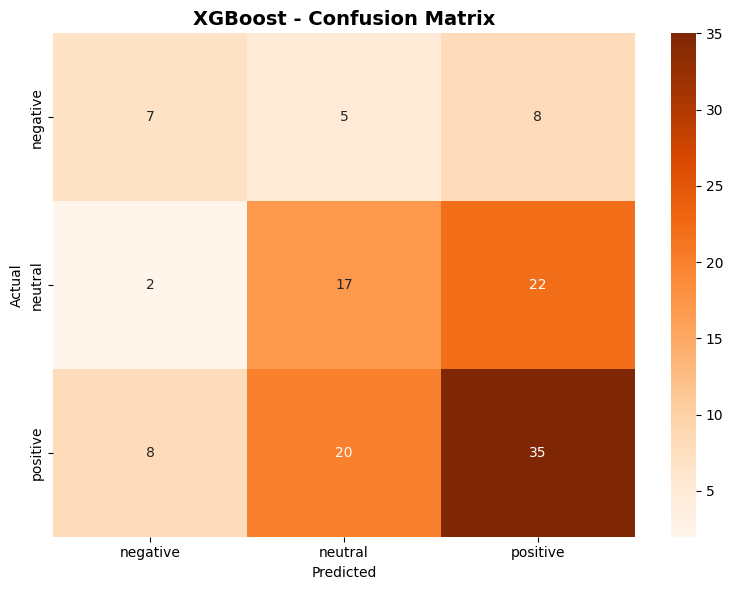

In [29]:
# Evaluate XGBoost
y_pred_xgb = grid_xgb.predict(X_test_enh)

xgb_accuracy = accuracy_score(y_test_enh, y_pred_xgb)
print(f"XGBoost Test Accuracy: {xgb_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enh, y_pred_xgb, target_names=target_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_xgb = confusion_matrix(y_test_enh, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('XGBoost - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Strategy 5: Voting Classifier (Ensemble of Best Models)

Training Voting Classifier...

Voting Classifier Test Accuracy: 0.4919

Classification Report:
              precision    recall  f1-score   support

    negative       0.45      0.45      0.45        20
     neutral       0.38      0.39      0.39        41
    positive       0.58      0.57      0.58        63

    accuracy                           0.49       124
   macro avg       0.47      0.47      0.47       124
weighted avg       0.49      0.49      0.49       124



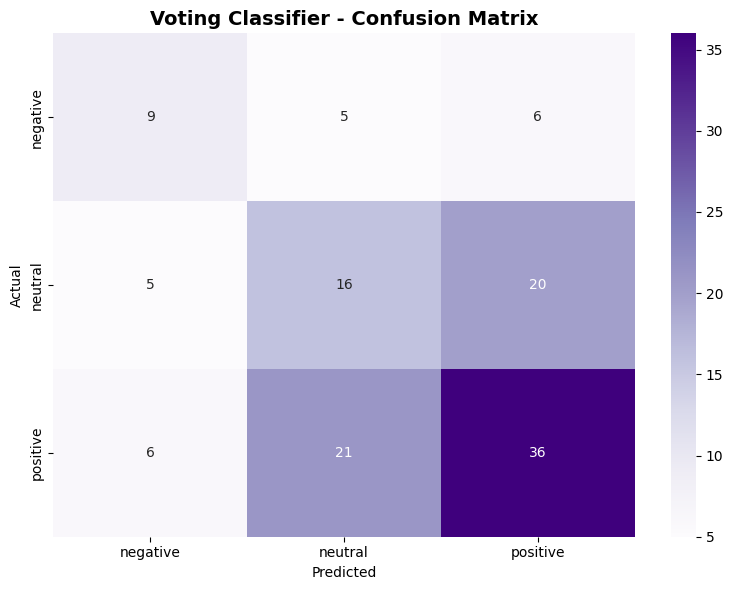

In [30]:
from sklearn.ensemble import VotingClassifier

# Combine the best models
voting_clf = VotingClassifier(
    estimators=[
        ('svm', grid_svm.best_estimator_),
        ('rf', grid_rf.best_estimator_),
        ('xgb', grid_xgb.best_estimator_)
    ],
    voting='hard'  # majority voting
)

print("Training Voting Classifier...")
voting_clf.fit(X_train_enh, y_train_enh)

# Evaluate
y_pred_voting = voting_clf.predict(X_test_enh)
voting_accuracy = accuracy_score(y_test_enh, y_pred_voting)

print(f"\nVoting Classifier Test Accuracy: {voting_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_enh, y_pred_voting, target_names=target_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_voting = confusion_matrix(y_test_enh, y_pred_voting)
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Purples', 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Voting Classifier - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Final Comparison of All Models

                         Model  Accuracy
                SVM (Original)  0.516129
        Naive Bayes (Original)  0.491935
  Voting Classifier (Enhanced)  0.491935
      Random Forest (Enhanced)  0.475806
            XGBoost (Enhanced)  0.475806
Logistic Regression (Original)  0.459677


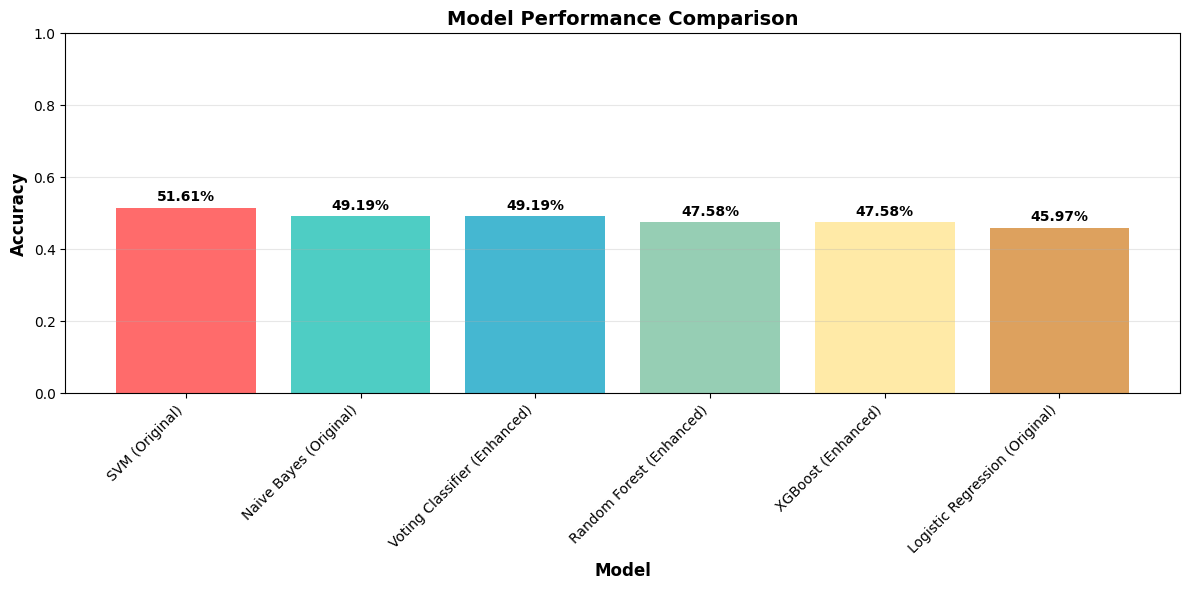


🎯 Best Model: SVM (Original)
   Accuracy: 51.61%

📈 Improvement: 0.00% over original best model


In [31]:
# Compare all models
model_comparison = pd.DataFrame({
    'Model': [
        'Logistic Regression (Original)',
        'SVM (Original)',
        'Naive Bayes (Original)',
        'Random Forest (Enhanced)',
        'XGBoost (Enhanced)',
        'Voting Classifier (Enhanced)'
    ],
    'Accuracy': [
        lr_accuracy,
        svm_accuracy,
        nb_accuracy,
        rf_accuracy,
        xgb_accuracy,
        voting_accuracy
    ]
})

model_comparison = model_comparison.sort_values('Accuracy', ascending=False)
print(model_comparison.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(model_comparison)), model_comparison['Accuracy'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA15E'])
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(range(len(model_comparison)), model_comparison['Model'], rotation=45, ha='right')
plt.ylim([0, 1])

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, model_comparison['Accuracy'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.2%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"\n🎯 Best Model: {model_comparison.iloc[0]['Model']}")
print(f"   Accuracy: {model_comparison.iloc[0]['Accuracy']:.2%}")
print(f"\n📈 Improvement: {(model_comparison.iloc[0]['Accuracy'] - svm_accuracy)*100:.2f}% over original best model")

### Additional Recommendations

**For further improvements:**

1. **Data Collection**: The most impactful improvement would be to collect more labeled data. Your current dataset is relatively small, which limits model performance.

2. **Deep Learning Approach**: For Khmer text, consider:
   - Using pre-trained multilingual models like XLM-RoBERTa
   - Fine-tuning BERT-based models
   - Implementing LSTM or Transformer architectures

3. **Feature Engineering**:
   - Add character-level n-grams (useful for Khmer)
   - Include text length features
   - Add sentiment lexicon features if available

4. **Data Augmentation**:
   - Back-translation
   - Synonym replacement
   - Random insertion/deletion

5. **Cross-validation**: Use k-fold cross-validation (k=5 or 10) for more robust evaluation

6. **Hyperparameter Tuning**: Use more extensive grid search or RandomizedSearchCV

Run the cells above to see which improvements work best for your dataset!